# Set Environment

In [34]:
#Import packages

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.optimize as opt
import glob 
import os
import matplotlib.lines as mlines

In [3]:
#Set functions for fitting dose response curves

def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))
def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(np.log10(x))

In [4]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Import Data
All data is collected from the Celigo and exported as object level data to a CSV. Pandas is used to manage data in python. 

In [5]:
# Import data (takes a while)
my_dir = '/Users/AmyAllen/Documents/ThesisWork/pher-response-quantification/Imaging Cytometry/WT bar1D Comparison'
filelist = []
os.chdir( my_dir )
for files in glob.glob( "*level.csv" ) :
    filelist.append(files)
dfs = []
time = []
for i, f in enumerate(filelist):
    df = pd.read_csv(f, header = 15)
    time += [i] * len(df)
    cell = np.linspace(1,len(df),len(df))
    df['nCell']=cell
    dfs.append(df)
    
df = pd.concat(dfs)
df['timepoint'] = time

options = {1:'100',2:'30',3:'10',4:'3',5:'1',6:'0.3',7:'0.1',8:'0.03',9:'0.01',10:'0.003',11:'0.001',12:'0.0001'}
df['Dose'] = df.replace({'Column': options})['Column']
df['Log dose'] = np.log10(df['Dose'].apply(pd.to_numeric))
df['Dose'] = df['Dose'].apply(pd.to_numeric)
df['Response'] = df['GFP: Integrated Intensity']
df['Normalized Response'] = df['GFP: Integrated Intensity']/df['mCherry: Integrated Intensity']

print(df.shape)
df.head()

2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-3-00-34-PM_Result_11-7-2018-3-06-41-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-3-20-34-PM_Result_11-7-2018-3-13-27-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-3-40-34-PM_Result_11-7-2018-3-20-13-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-4-00-34-PM_Result_11-7-2018-3-27-00-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-4-20-34-PM_Result_11-7-2018-3-33-48-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-4-40-34-PM_Result_11-7-2018-3-40-38-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-5-00-34-PM_Result_11-7-2018-3-47-29-PM_objectlevel.csv
2018Oct31_Lorena_bar1DWT_Scan_10-31-2018-5-20-34-PM_Result_11-7-2018-3-54-20-PM_objectlevel.csv
(4275299, 23)


,Well,Row,Column,Total,Not Debris,Single cells,Class 3,Class 4,X Position (µm),Y Position (µm),...,Aspect Ratio,GFP: Mean Intensity,GFP: Integrated Intensity,bright field: Mean Intensity,bright field: Integrated Intensity,nCell,timepoint,Dose,Log dose,Response
0,A1,A,1,False,True,True,False,False,-1144.891724,-1700.655396,...,1.000000,1.454545,32.0,107.409088,2363,1.0,0,100.0,2.0,32.0
1,A1,A,1,False,True,False,False,False,-1371.881470,-1532.315063,...,0.432207,1.333333,12.0,109.444443,985,2.0,0,100.0,2.0,12.0
2,A1,A,1,False,True,True,False,False,-1557.284790,-1395.776978,...,0.589630,0.882353,15.0,107.000000,1819,3.0,0,100.0,2.0,15.0
3,A1,A,1,False,True,True,False,False,-1825.955444,-1192.029297,...,0.624296,3.333333,40.0,97.333336,1168,4.0,0,100.0,2.0,40.0
4,A1,A,1,False,True,True,False,False,-1809.564697,-1186.001343,...,0.597400,2.700000,27.0,97.599998,976,5.0,0,100.0,2.0,27.0


In [6]:
# Subset only single cells
df = df[df['Single cells']==True]
df.shape

(2633367, 23)

# Analyze dose response curves

In [18]:
# Format data for each row
# Row A
RowA = df[df['Row']=='A']
RowA = RowA.dropna()
AVG_GFP_A = np.array(RowA.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_A = np.array(RowA.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_A = np.array(RowA.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_A = pd.DataFrame(
    {'response': AVG_GFP_A,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_A,
     'Noise': SD_GFP_A/AVG_GFP_A
    })

# Row B
RowB = df[df['Row']=='B']
RowB = RowB.dropna()
AVG_GFP_B = np.array(RowB.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_B = np.array(RowB.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_B = np.array(RowB.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_B = pd.DataFrame(
    {'response': AVG_GFP_B,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_B,
     'Noise': SD_GFP_B/AVG_GFP_B
    })

# Row C
RowC = df[df['Row']=='C']
RowC = RowC.dropna()
AVG_GFP_C = np.array(RowC.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_C = np.array(RowC.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_C = np.array(RowC.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_C = pd.DataFrame(
    {'response': AVG_GFP_C,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_C,
     'Noise': SD_GFP_C/AVG_GFP_C
    })

# Row D
RowD = df[df['Row']=='D']
RowD = RowD.dropna()
AVG_GFP_D = np.array(RowD.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_D = np.array(RowD.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_D = np.array(RowD.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_D = pd.DataFrame(
    {'response': AVG_GFP_D,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_D,
     'Noise': SD_GFP_D/AVG_GFP_D
    })

# Row E
RowE = df[df['Row']=='E']
RowE = RowE.dropna()
AVG_GFP_E = np.array(RowE.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_E = np.array(RowE.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_E = np.array(RowE.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_E = pd.DataFrame(
    {'response': AVG_GFP_E,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_E,
     'Noise': SD_GFP_E/AVG_GFP_E
    })

# Row F
RowF = df[df['Row']=='F']
RowF = RowF.dropna()
AVG_GFP_F = np.array(RowF.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_F = np.array(RowF.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_F = np.array(RowF.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_F = pd.DataFrame(
    {'response': AVG_GFP_F,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_F,
     'Noise': SD_GFP_F/AVG_GFP_F
    })

# Row G
RowG = df[df['Row']=='G']
RowG = RowG.dropna()
AVG_GFP_G = np.array(RowG.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_G = np.array(RowG.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_G = np.array(RowG.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_G = pd.DataFrame(
    {'response': AVG_GFP_G,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_G,
     'Noise': SD_GFP_G/AVG_GFP_G
    })

# Row H
RowH = df[df['Row']=='H']
RowH = RowH.dropna()
AVG_GFP_H = np.array(RowG.groupby(['timepoint','Column']).mean()['GFP: Integrated Intensity'])
SD_GFP_H = np.array(RowG.groupby(['timepoint','Column'])['GFP: Integrated Intensity'].std())
Log_Dose_H = np.array(RowG.groupby(['timepoint','Column']).mean()['Log dose'])
Columns = []
n_tp = 8
for i in range(n_tp):
    Columns.append(np.linspace(1,12,12))
columns = [item for sublist in Columns for item in sublist]
Times = []
for i in range(n_tp):
    Times.append(np.repeat(i, 12))
times = [item for sublist in Times for item in sublist]
plot_list_H = pd.DataFrame(
    {'response': AVG_GFP_H,
     'column': columns,
     'timepoint': times,
     'LogDose': Log_Dose_H,
     'Noise': SD_GFP_H/AVG_GFP_H
    })

In [22]:
# Average technical replicates
tp = 7 # set time point of interest
WT = []
bar1D = []

for i in range(12):
    WT.append(np.mean([np.array(plot_list_A[plot_list_A.timepoint==tp]['response'])[i],
                       np.array(plot_list_B[plot_list_B.timepoint==tp]['response'])[i],
                       np.array(plot_list_C[plot_list_C.timepoint==tp]['response'])[i],
                       np.array(plot_list_D[plot_list_D.timepoint==tp]['response'])[i]]))
    bar1D.append(np.mean([np.array(plot_list_E[plot_list_E.timepoint==tp]['response'])[i],
                          np.array(plot_list_F[plot_list_F.timepoint==tp]['response'])[i],
                          np.array(plot_list_G[plot_list_G.timepoint==tp]['response'])[i],
                          np.array(plot_list_H[plot_list_H.timepoint==tp]['response'])[i]]))

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


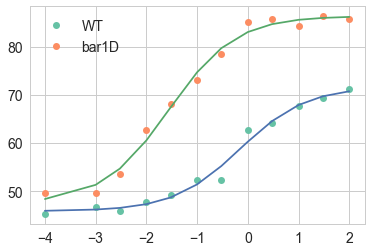

In [24]:
# Fit dose response curve to averages
doses = [100,30,10,3,1,0.3,0.1,0.03,0.01,0.003,0.001,0.0001]
log_doses = np.log10(doses)
fits= []
fitCoefs, covMatrix = opt.curve_fit(ll4, doses, WT)
curFit = dict(zip(['b','c','d','e'],fitCoefs))
fits.append(curFit)
fitCoefs, covMatrix = opt.curve_fit(ll4, doses, bar1D)
curFit = dict(zip(['b','c','d','e'],fitCoefs))
fits.append(curFit)

# Plot comparison
plt.plot(log_doses,WT,'o',label = 'WT',color=pallet[0])
plt.plot(log_doses,bar1D,'o',label = 'bar1D',color=pallet[1])

for k, fit in enumerate(fits):
    plt.plot([pDose(i) for i in doses],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in doses])
plt.legend()

In [26]:
# Export all data to excel for plotting in GraphPad Prism

# WT
appended_data = []
for j in range(8):
    bar1D_ph = []
    for i in range(12):
        bar1D_ph.append([np.array(plot_list_A[plot_list_A.timepoint==j]['response'])[i],
                         np.array(plot_list_B[plot_list_B.timepoint==j]['response'])[i],
                         np.array(plot_list_C[plot_list_C.timepoint==j]['response'])[i],
                         np.array(plot_list_D[plot_list_D.timepoint==j]['response'])[i]])
        bar1D = pd.DataFrame(noBSA)
    appended_data.append(bar1D)

appended = pd.concat(appended_data, axis=1)

appended.to_excel('WT.xlsx')

# bar1D
appended_data = []
for j in range(8):
    bar1D_ph = []
    for i in range(12):
        bar1D_ph.append([np.array(plot_list_E[plot_list_E.timepoint==j]['response'])[i],
                         np.array(plot_list_F[plot_list_F.timepoint==j]['response'])[i],
                         np.array(plot_list_G[plot_list_G.timepoint==j]['response'])[i],
                         np.array(plot_list_H[plot_list_H.timepoint==j]['response'])[i]])
        bar1D = pd.DataFrame(noBSA)
    appended_data.append(bar1D)

appended = pd.concat(appended_data, axis=1)

appended.to_excel('bar1D.xlsx')

# Track Individual Cells
Using the TrackPy Package to track individual cells

In [27]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import pims
import trackpy as tp

Frame 7: 4738 trajectories present
Before: 30489
After: 121


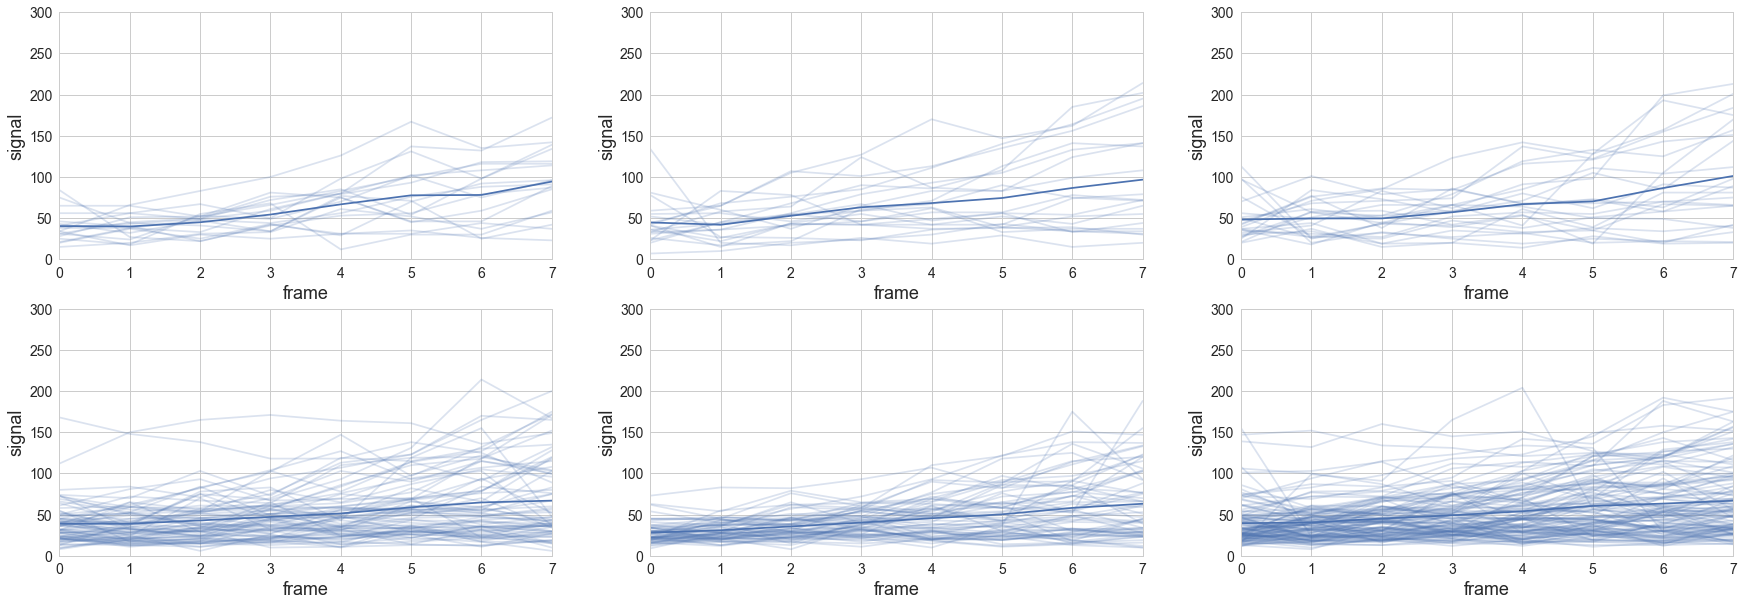

In [30]:
# Track bar1D cells at high pheromone doses
# fig, axes = plt.subplots(2, 12,figsize=(20, 10))
fig1, axes1 = plt.subplots(2, 3,figsize=(30, 10))
# flat_axes = [val for sublist in axes for val in sublist]
flat_axes1 = [val for sublist in axes1 for val in sublist]
ncells = []
for i, w in enumerate(['G1','G2','G3',
                       'E1','E2','E3']):
    dfG1 = df[df.Well==w]
    tracking = dfG1[['timepoint','X Position (µm)','Y Position (µm)','Area (µm²)','Response']]
    tracking.columns = ['frame', 'x','y','size','signal']
    t = tp.link_df(tracking, 8, memory=1)
    t1 = tp.filter_stubs(t, 8)
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    ncells.append(t1['particle'].nunique())
    if t1.empty==False:
#         tp.plot_traj(t1,ax=flat_axes[i])
    
        sns.tsplot(time='frame', 
                   data=t1, 
                   value='signal', 
                   unit='particle',
                   err_style='unit_traces',
                   ax=flat_axes1[i])
    flat_axes1[i].set_ylim(0,300)

# Heatmap

In [62]:
hm = []
for j in [7]:
    temp = []
    for i in range(12):
        temp.append([np.array(plot_list_A[plot_list_A.timepoint==j]['response'])[i],
                     np.array(plot_list_B[plot_list_B.timepoint==j]['response'])[i],
                     np.array(plot_list_C[plot_list_C.timepoint==j]['response'])[i],
                     np.array(plot_list_D[plot_list_D.timepoint==j]['response'])[i],
                     np.array(plot_list_E[plot_list_E.timepoint==j]['response'])[i],
                     np.array(plot_list_F[plot_list_F.timepoint==j]['response'])[i],
                     np.array(plot_list_G[plot_list_G.timepoint==j]['response'])[i],
                     np.array(plot_list_H[plot_list_H.timepoint==j]['response'])[i]])
    hm.append(temp)
df_hm = pd.DataFrame(hm[0])
df_hm = df_hm.transpose()
sns.heatmap(df_hm)

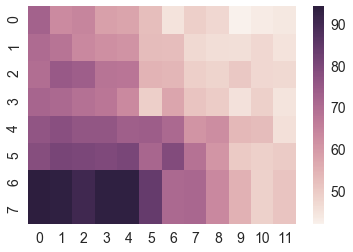

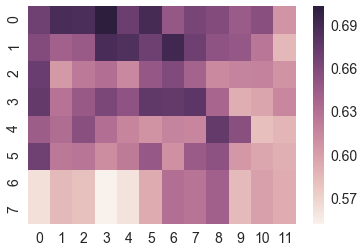

In [65]:
hm = []
for j in [7]:
    temp = []
    for i in range(12):
        temp.append([np.array(plot_list_A[plot_list_A.timepoint==j]['Noise'])[i],
                     np.array(plot_list_B[plot_list_B.timepoint==j]['Noise'])[i],
                     np.array(plot_list_C[plot_list_C.timepoint==j]['Noise'])[i],
                     np.array(plot_list_D[plot_list_D.timepoint==j]['Noise'])[i],
                     np.array(plot_list_E[plot_list_E.timepoint==j]['Noise'])[i],
                     np.array(plot_list_F[plot_list_F.timepoint==j]['Noise'])[i],
                     np.array(plot_list_G[plot_list_G.timepoint==j]['Noise'])[i],
                     np.array(plot_list_H[plot_list_H.timepoint==j]['Noise'])[i]])
    hm.append(temp)
df_hm = pd.DataFrame(hm[0])
df_hm = df_hm.transpose()
sns.heatmap(df_hm)